In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
# from sklearn.preprocessing import LabelEncoder


2025-04-17 18:53:50.844458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# COCO limb pairs
LIMB_PAIRS = [
    (5, 7), (7, 9),     # Left arm
    (6, 8), (8, 10),    # Right arm
    (11, 13), (13, 15), # Left leg
    (12, 14), (14, 16), # Right leg
    (5, 6), (11, 12),   # Shoulders, hips
    (0, 1), (0, 2), (1, 3), (2, 4)  # Head
]

COCO_MAP = {
    0: 0, 1: 2, 2: 5, 3: 7, 4: 8,
    5: 11, 6: 12, 7: 13, 8: 14, 9: 15,
    10: 16, 11: 23, 12: 24, 13: 25,
    14: 26, 15: 27, 16: 28
}

def mediapipe_to_coco(mp_landmarks, width, height):
    keypoints_coco = []
    for coco_id in range(17):
        mp_id = COCO_MAP[coco_id]
        lm = mp_landmarks[mp_id]
        x = int(lm.x * width)
        y = int(lm.y * height)
        keypoints_coco.append((x, y, lm.visibility))
    return keypoints_coco

def draw_limb_heatmap(keypoints, image_size, sigma=8):
    h, w = image_size
    heatmap = np.zeros((h, w), dtype=np.float32)

    for (start_idx, end_idx) in LIMB_PAIRS:
        x1, y1, s1 = keypoints[start_idx]
        x2, y2, s2 = keypoints[end_idx]
        if s1 < 0.1 or s2 < 0.1:
            continue
        canvas = np.zeros((h, w), dtype=np.uint8)
        cv2.line(canvas, (x1, y1), (x2, y2), color=255, thickness=2*sigma)
        canvas = cv2.GaussianBlur(canvas, (0, 0), sigmaX=sigma, sigmaY=sigma)
        canvas = canvas.astype(np.float32) / 255.0
        heatmap = np.maximum(heatmap, canvas)
    return heatmap



2025-05-16 19:14:13.414484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/apple/miniconda3/envs/ML/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Load the dataset of cropped player frames and convert it into heatmap dataset of frames

In [2]:
X = np.load('/Users/apple/Desktop/newData/X-smash2.npy')

In [3]:
X.shape

(47, 10, 250, 250, 3)

In [4]:
pose = mp.solutions.pose.Pose(min_detection_confidence=0.7,min_tracking_confidence=0.7)
Xh = []
for i in range(0,X.shape[0]):
    f = []
    for j in range(0,10):
        img = X[i][j]
        h,w = img.shape[:2]
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         pose = mp.solutions.pose.Pose(static_image_mode=True)
#         pose = mp.solutions.pose.Pose(min_detection_confidence=0.7,min_tracking_confidence=0.7)
        results = pose.process(img_rgb)
        
        if results.pose_landmarks:
            keypoints_coco = mediapipe_to_coco(results.pose_landmarks.landmark, w, h)
            heatmap = draw_limb_heatmap(keypoints_coco, (h, w))
            
            f.append(heatmap)

    f = np.asarray(f)
    if f.shape[0]==10:
        Xh.append(f)

Xh = np.asarray(Xh)
print(Xh.shape)



I0000 00:00:1747403075.371974   55437 gl_context.cc:369] GL version: 2.1 (2.1 ATI-4.14.1), renderer: AMD Radeon Pro 555 OpenGL Engine
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747403075.529932   56825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747403075.564898   56824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747403075.586723   56826 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


(47, 10, 250, 250)


In [6]:
k=0

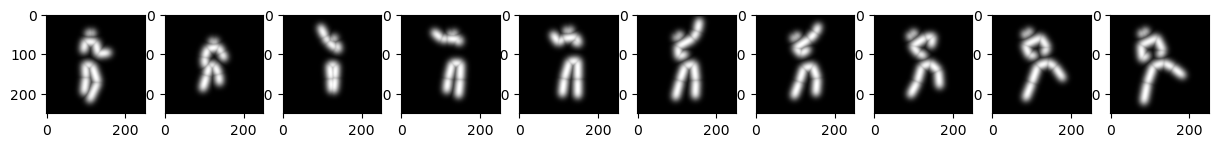

In [7]:
plt.figure(figsize=(15,8))
for i in range(0,10):
    plt.subplot(5,10,i+1)
    plt.imshow(Xh[k][i],cmap='gray')

k+=1
    

In [39]:
np.save('/Users/apple/Desktop/newData/HX-smash.npy',Xh)